In [200]:
# set up the environment
%pylab
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import seaborn as sns
sns.set()
import pandas as pd
import scipy as sp
import scipy.stats
import statsmodels.stats.api as sms
import statsmodels.api as sm
import statsmodels.formula.api as smf

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


/Users/kallus/Applications/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['beta']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [201]:
with open('prostate.data') as f:
    prostate = pd.read_table(f)
del prostate[prostate.columns[0]]
del prostate[prostate.columns[-1]]
prostate.head()


,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
0,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783
1,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519
2,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519
3,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519
4,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564


In [202]:
data = prostate
response = 'lpsa'
singlefeatures=list(set(data.columns)-{response})
print singlefeatures

['gleason', 'pgg45', 'lcp', 'svi', 'age', 'lcavol', 'lweight', 'lbph']


In [203]:
import itertools
interactions = ['%s:%s'%v for v in itertools.combinations(singlefeatures,2)]
print interactions[:10]

['gleason:pgg45', 'gleason:lcp', 'gleason:svi', 'gleason:age', 'gleason:lcavol', 'gleason:lweight', 'gleason:lbph', 'pgg45:lcp', 'pgg45:svi', 'pgg45:age']


In [204]:
lm = smf.ols(response+' ~ '+'+'.join(singlefeatures), data=data).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   lpsa   R-squared:                       0.663
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                     21.68
Date:                Mon, 19 Mar 2018   Prob (F-statistic):           7.65e-18
Time:                        15:32:03   Log-Likelihood:                -98.248
No. Observations:                  97   AIC:                             214.5
Df Residuals:                      88   BIC:                             237.7
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1816      1.321      0.137      0.891      -2.443       2.806
gleason        0.0492      0.155      0.317      0.752      -0.259       0.358
pgg45          0.0045      0.004      1.021      0.310      -0.004       0.013
lcp           -0.1061      0.090     -1.180      0.241      -0.285       0.073
svi            0.7617      0.241      3.158      0.002       0.282       1.241
age           -0.0212      0.011     -1.917      0.058      -0.043       0.001
lcavol         0.5643      0.088      6.425      0.000       0.390       0.739
lweight        0.6220      0.201      3.096      0.003       0.223       1.021
lbph           0.0967      0.058      1.670      0.098      -0.018       0.212
==============================================================================
Omnibus:                        0.563   Durbin-Watson:                   1.540
Prob(Omnibus):                  0.755   Jarque-Bera (JB):                0.183
Skew:                           0.017   Prob(JB):                        0.913
Kurtosis:                       3.210   Cond. No.                     1.32e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.32e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [205]:
lm.aic

214.49521411610266

In [206]:
def fitmodel(S,data,response):
    return smf.ols(response+' ~ '+('+'.join(S) if len(S)>0 else '1'), data=data).fit()
def getaic(lm):
    return lm.aic
mycriterion = getaic

In [207]:
## forward stepwise
Sfwd = set()
# features = set(singlefeatures)
features = set(singlefeatures).union(set(interactions))
while len(Sfwd)<len(features):
    f = max(features - Sfwd, key = lambda f: mycriterion(fitmodel(Sfwd.union({f}),data,response)))
    after = mycriterion(fitmodel(Sfwd.union({f}),data,response))
    before = mycriterion(fitmodel(Sfwd,data,response))
    if after > before:
        Sfwd = Sfwd.union({f})
    else:
        break
print Sfwd
    

set(['svi:lbph', 'lcavol:lbph'])


In [208]:
## backward stepwise
# features = set(singlefeatures)
features = set(singlefeatures).union(set(interactions))
Sbwd = set(features)
while len(Sbwd)>0:
    f = max(Sbwd, key = lambda f: mycriterion(fitmodel(Sbwd-{f},data,response)))
    after = mycriterion(fitmodel(Sbwd-{f},data,response))
    before = mycriterion(fitmodel(Sbwd,data,response))
    if after > before:
        Sbwd = Sbwd-{f}
    else:
        break
print Sbwd
    

set(['svi:age', 'gleason:lcavol', 'lweight', 'pgg45:lcavol', 'lcavol:lbph', 'lcp:lbph', 'pgg45:lweight', 'pgg45', 'gleason:lbph', 'pgg45:lcp', 'gleason:svi', 'lcp:svi', 'gleason:age', 'age:lweight', 'gleason', 'gleason:pgg45', 'lcp', 'svi:lbph', 'age:lbph', 'pgg45:svi', 'lcp:lcavol', 'lcavol:lweight', 'lcp:lweight', 'svi', 'age', 'svi:lweight', 'svi:lcavol', 'age:lcavol', 'lcavol', 'lbph'])


In [209]:
## stepwise
Sboth = Sfwd if mycriterion(fitmodel(Sfwd,data,response)) > mycriterion(fitmodel(Sbwd,data,response)) else Sbwd
print Sboth


set(['svi:lbph', 'lcavol:lbph'])


In [210]:
print fitmodel(features,data,response).aic
print fitmodel(Sfwd,data,response).aic
print fitmodel(Sbwd,data,response).aic
print fitmodel(Sboth,data,response).aic


229.422658202
306.532631721
240.270532295
306.532631721


In [213]:
lm = smf.ols(response+' ~ '+'+'.join(Sboth), data=data).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   lpsa   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.7713
Date:                Mon, 19 Mar 2018   Prob (F-statistic):              0.465
Time:                        15:35:43   Log-Likelihood:                -150.27
No. Observations:                  97   AIC:                             306.5
Df Residuals:                      94   BIC:                             314.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       2.4656      0.119     20.788      0.000       2.230       2.701
svi:lbph       -0.2850      0.243     -1.173      0.244      -0.767       0.197
lcavol:lbph     0.0245      0.060      0.410      0.682      -0.094       0.143
==============================================================================
Omnibus:                        2.760   Durbin-Watson:                   0.040
Prob(Omnibus):                  0.252   Jarque-Bera (JB):                2.629
Skew:                           0.027   Prob(JB):                        0.269
Kurtosis:                       3.805   Cond. No.                         5.35
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [224]:
# folds = 10
folds = 100
idxs = np.arange(len(data),dtype='i')/int(np.ceil(len(data)/float(folds)))
idxs

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96], dtype=int32)

In [215]:
def CV_MSE(response, features, data, idxs):
    fs = max(idxs)+1
    mses = np.zeros(fs)
    for f in range(fs):
        mses[f] = ((data[idxs==f][response]
            -
            fitmodel(features,data[idxs!=f],response).predict(data[idxs==f]))**2).mean()
    return mses.mean(), mses.std(ddof=1)/np.sqrt(fs)


In [225]:
CV_MSE(response,Sboth,data,idxs)

(1.3905174029101879, 0.2393445009003656)

In [226]:
CV_MSE(response,features,data,idxs)

(0.54132905390533437, 0.083703795097385916)

In [218]:
def getssr(lm):
    return -lm.ssr
mycriterion = getssr

In [227]:
## forward stepwise CV
features = set(singlefeatures)
# features = set(singlefeatures).union(set(interactions))
S = set()
Ss  = [None for i in range(len(features)+1)]
CVs = np.zeros(len(features)+1)
SEs = np.zeros(len(features)+1)
while True:
    Ss[len(S)] = S
    CVs[len(S)],SEs[len(S)] = CV_MSE(response,S,data,idxs)
    if len(S)>=len(features):
        break
    f = max(features - S, key = lambda f: mycriterion(fitmodel(S.union({f}),data,response)))
    S = S.union({f})


In [228]:
CVs.min()

0.52552752191650132

In [229]:
Sfwdvc0=Ss[CVs.argmin()]
Sfwdvc0

{'lcavol', 'lweight', 'svi'}

<Container object of 3 artists>

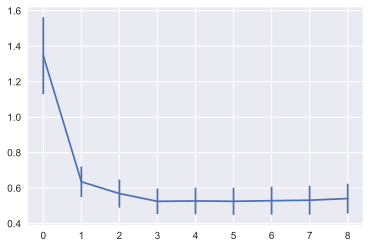

In [230]:
errorbar(range(len(features)+1), CVs, yerr=SEs)

In [231]:
## stepwise fwd regression with one-standard-error rule
Sfwdvc1=Ss[np.where(CVs<=CVs.min()+SEs[CVs.argmin()])[0][0]]
Sfwdvc1

{'lcavol', 'lweight'}

In [232]:
from sklearn import linear_model
import patsy
holdout = 10
features = list(set(singlefeatures).union(set(interactions)))
X=patsy.dmatrix('+'.join(features)+'-1',data)
Y=data[response]
ridge = linear_model.RidgeCV().fit(X[holdout:],Y[holdout:])
ols = smf.ols(response+' ~ '+'+'.join(features), data=data[holdout:]).fit()


In [233]:
print ((ols.predict(data[:holdout])-data[response][:holdout])**2).mean()
print ((ridge.predict(X[:holdout])-Y[:holdout])**2).mean()


2.74046226328
2.10103026293


In [234]:
from sklearn import linear_model
import patsy
holdout = 10
features = list(set(singlefeatures).union(set(interactions)))
X=patsy.dmatrix('+'.join(features)+'-1',data)
Y=data[response]
lasso = linear_model.LassoCV().fit(X[holdout:],Y[holdout:])
ols = smf.ols(response+' ~ '+'+'.join(features), data=data[holdout:]).fit()


/Users/kallus/Applications/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [235]:
print ((ols.predict(data[:holdout])-data[response][:holdout])**2).mean()
print ((lasso.predict(X[:holdout])-Y[:holdout])**2).mean()


2.74046226328
2.03883662242


In [236]:
lasso.coef_

array([ 0.01146079, -0.        ,  0.        ,  0.        ,  0.00829897,
       -0.00017829, -0.        , -0.        ,  0.00093953,  0.        ,
        0.        , -0.00723929,  0.        ,  0.00052736,  0.        ,
       -0.00415825,  0.00314955,  0.        ,  0.00072485,  0.        ,
       -0.        ,  0.        ,  0.00149471,  0.        , -0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.        ,  0.        ,  0.        ,  0.00566784,  0.        ,  0.        ])

In [237]:
np.array(features)[np.abs(lasso.coef_)>1e-10]

array(['svi:age', 'pgg45:lcavol', 'pgg45:age', 'pgg45:lweight',
       'pgg45:lcp', 'lcp:age', 'gleason:age', 'age:lweight',
       'gleason:pgg45', 'age:lbph', 'age:lcavol'], 
      dtype='|S15')

In [238]:
ols2 = smf.ols(response+' ~ '+'+'.join(np.array(features)[lasso.coef_>0]), data=data[holdout:]).fit()
print ((ols2.predict(data[:holdout])-data[response][:holdout])**2).mean()

2.30890511517


In [240]:

holdout = 10
features = list(set(singlefeatures).union(set(interactions)))
X=patsy.dmatrix('+'.join(features)+'-1',data)
Y=data[response]
en = linear_model.ElasticNetCV(l1_ratio=0.5).fit(X[holdout:],Y[holdout:])
ols = smf.ols(response+' ~ '+'+'.join(features), data=data[holdout:]).fit()


In [241]:
print ((ols.predict(data[:holdout])-data[response][:holdout])**2).mean()
print ((en.predict(X[:holdout])-Y[:holdout])**2).mean()


2.74046226328
2.03900878728


In [242]:
np.array(features)[np.abs(en.coef_)>1e-10]

array(['svi:age', 'pgg45:lcavol', 'pgg45:age', 'pgg45:lweight',
       'pgg45:lcp', 'lcp:age', 'gleason:age', 'age:lweight',
       'gleason:pgg45', 'age:lbph', 'age:lcavol'], 
      dtype='|S15')

In [243]:
ols2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   lpsa   R-squared:                       0.505
Model:                            OLS   Adj. R-squared:                  0.454
Method:                 Least Squares   F-statistic:                     9.932
Date:                Mon, 19 Mar 2018   Prob (F-statistic):           2.01e-09
Time:                        16:33:28   Log-Likelihood:                -87.293
No. Observations:                  87   AIC:                             192.6
Df Residuals:                      78   BIC:                             214.8
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         2.1577      0.475      4.542      0.000       1.212       3.103
svi:age           0.0116      0.004      3.150      0.002       0.004       0.019
pgg45:lcavol      0.0026      0.003      0.808      0.421      -0.004       0.009
pgg45:lweight     0.0055      0.004      1.488      0.141      -0.002       0.013
lcp:age          -0.0018      0.001     -1.193      0.236      -0.005       0.001
age:lweight      -0.0016      0.002     -0.736      0.464      -0.006       0.003
gleason:pgg45    -0.0028      0.002     -1.678      0.097      -0.006       0.001
age:lbph          0.0012      0.001      1.297      0.198      -0.001       0.003
age:lcavol        0.0060      0.002      3.670      0.000       0.003       0.009
==============================================================================
Omnibus:                        2.736   Durbin-Watson:                   1.041
Prob(Omnibus):                  0.255   Jarque-Bera (JB):                2.106
Skew:                           0.242   Prob(JB):                        0.349
Kurtosis:                       3.590   Cond. No.                     2.56e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.56e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [244]:
d = 100
beta = np.hstack((np.ones(d/2),np.zeros(d/2)))
def generate_data(n):
    X = np.random.randn(n,d)
    Y = X.dot(beta) + np.random.randn()
    return Y,X

In [245]:
np.random.seed(0)
y,x = generate_data(1)
print sm.OLS(*generate_data(200)).fit().get_prediction(x).se_mean[0]
preds = [sm.OLS(*generate_data(200)).fit().predict(x) for i in range(200)]
print np.std(preds)


1.19594889216
1.0088192231


In [252]:
np.random.seed(0)
n = 50
Y,X = generate_data(n)
lasso = linear_model.LassoCV().fit(X,Y)
lassofeatures = np.abs(lasso.coef_)>1e-10
print lassofeatures
print sm.OLS(Y,X[:,lassofeatures]).fit().get_prediction(x[:,lassofeatures]).se_mean[0]


[ True False False False False  True  True False False  True False False
  True False  True  True  True  True False False False False False False
  True  True False False  True False False  True False  True False False
 False  True  True False False False False  True  True  True False  True
 False False False False False False False False False False  True  True
 False False False False False False False  True False False  True  True
 False False False False False False False False False  True False False
 False False False  True False False False  True False False  True  True
 False False False False]
1.09262759432


In [251]:
lamb = lasso.alpha_
preds = np.zeros(200)
for i in range(200):
    Y,X = generate_data(n)
    lasso = linear_model.Lasso(alpha=lamb).fit(X,Y)
    lassofeatures = np.abs(lasso.coef_)>1e-10
    preds[i] = sm.OLS(Y,X[:,lassofeatures]).fit().predict(x[:,lassofeatures])[0]
print np.std(preds)

5.9619919711
